In [2]:
import numpy as np
import voxelmorph as vxm
# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import notebook as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()

In [6]:
# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

In [7]:
# let's load up MNIST
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train_all = x_train_all.astype('float')/255
x_test_all = x_test_all.astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

vol_shape = list(x_train_all.shape[1:-1])

In [8]:
# extract all 3s
digit = 3

x_train = x_train_all[y_train_all == digit,...][:8]
y_train = y_train_all[y_train_all == digit]
x_test = x_test_all[y_test_all == digit, ...].astype('float')/255
y_test = y_test_all[y_test_all == digit]

In [9]:
xslice = K.batch_flatten(x_train)[:, 0:1]
b = xslice * tf.zeros((1,), dtype=x_train.dtype) + tf.ones((1,), dtype=x_train.dtype)
# b = K.batch_flatten(0 * x)[:, 0:1] + 1
# params = K.flatten(self.kernel * self.biasmult)[tf.newaxis, ...]

In [10]:
# prepare a simple generator. 
tf.random.set_seed(10086)
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = img
    outputs = [img, zero, zero, zero]
    yield inputs, outputs

# let's make sure the sizes make sense
sample = next(template_gen(x_train, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(32, 32, 1),
  (32, 32, 1),
  (32, 32, 1),
  (32, 32, 1),
  (32, 32, 1),
  (32, 32, 1),
  (32, 32, 1),
  (32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

In [11]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [12]:
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TypeError: in user code:

    /home/junyi/Documents/scripts/registration/voxelmorph/voxelmorph/tf/layers.py:252 call  *
        out = tf.map_fn(self._single_int,
    /home/junyi/.conda/envs/tf2/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574 new_func  **
        return func(*args, **kwargs)

    TypeError: map_fn_v2() got an unexpected keyword argument 'fn_output_signature'


In [25]:
mean_atlas = np.mean(x_train, 0,keepdims=True)
model.set_atlas(mean_atlas)
output = model(x_train)

In [26]:
K.eval(K.mean(output[2]))

1.0235026e-06

In [13]:
model.summary()

Model: "template_creation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source_input (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
atlas (LocalParamWithInput)     (None, 32, 32, 1)    1024        source_input[0][0]               
__________________________________________________________________________________________________
vxm_dense_unet_input_concat (Co (None, 32, 32, 2)    0           atlas[0][0]                      
                                                                 source_input[0][0]               
__________________________________________________________________________________________________
vxm_dense_unet_enc_conv_0_0 (Co (None, 32, 32, 16)   304         vxm_dense_unet_in

In [20]:
K.eval(model.get_layer('mean_stream').cap)

100.0

In [21]:
plt.imshow(K.eval(model.get_layer('mean_stream').output)[...,0])

InvalidArgumentError: You must feed a value for placeholder tensor 'source_input' with dtype float and shape [?,32,32,1]
	 [[node source_input (defined at home/junyi/Documents/scripts/registration/voxelmorph/voxelmorph/tf/networks.py:786) ]]

Original stack trace for 'source_input':
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
    await self.process_one()
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 505, in process_one
    await dispatch(*args)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
    await result
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
    reply_content = await reply_content
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
    result = self._run_cell(
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
    result = runner(coro)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_2462226/2840950266.py", line 1, in <module>
    model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/neurite-0.2-py3.8.egg/neurite/tf/modelio.py", line 22, in wrapper
    retval = func(self, *args, **kwargs)
  File "home/junyi/Documents/scripts/registration/voxelmorph/voxelmorph/tf/networks.py", line 786, in __init__
    source_input = tf.keras.Input(shape=[*inshape, src_feats], name='source_input')
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_layer.py", line 309, in Input
    input_layer = InputLayer(**input_layer_config)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_layer.py", line 155, in __init__
    input_tensor = backend.placeholder(
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/keras/backend.py", line 1265, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 3179, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6725, in placeholder
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3528, in _create_op_internal
    ret = Operation(
  File "home/junyi/.conda/envs/vxm-tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()


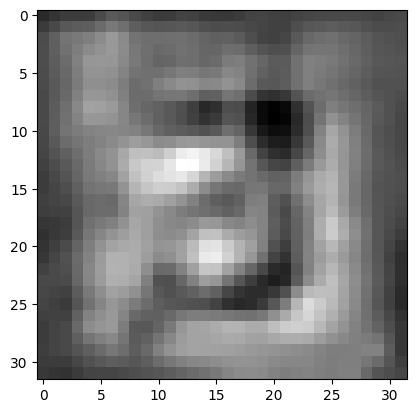

In [23]:
plt.imshow((K.eval(output[2])[2,...,0].squeeze()),cmap='gray')

In [35]:
def outputs(y_true, y_pred):
    return y_pred
batch_print_callback = callbacks.LambdaCallback(
    on_batch_end=lambda batch,logs: print(logs['vxm_dense_transformer_loss']))

In [38]:
# prepare losses and compile
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]
mean_atlas = np.mean(x_train, 0,keepdims=True)
model.set_atlas(mean_atlas)
model.compile('adam', loss=losses, loss_weights=loss_weights,)

In [39]:
# train model
gen = template_gen(x_train, batch_size=8)
hist = model.fit(gen, epochs=5, steps_per_epoch=1, verbose=0, callbacks=[tqdm_cb,batch_print_callback])

Training:   0%|           0/5 ETA: ?s,  ?epochs/s2023-08-13 23:50:58.905845: W tensorflow/c/c_api.cc:326] Operation '{name:'vxm_dense_flow_resize/map/while' id:827 op device:{} def:{{{node vxm_dense_flow_resize/map/while}} = StatelessWhile[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_INT32, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=249, _read_only_resource_inputs=[], body=vxm_dense_flow_resize_map_while_body_315[], cond=vxm_dense_flow_resize_map_while_cond_314[], output_shapes=[[], [], [], [], [], ..., [], [], [], [], []], parallel_iterations=10](vxm_dense_flow_resize/map/while/loop_counter, vxm_dense_flow_resize/map/strided_slice, vxm_dense_flow_resize/map/Const, vxm_dense_flow_resize/map/TensorArrayV2_1, vxm_dense_flow_resize/map/strided_slice, vxm_dense_flow_resize/map/TensorArrayUnstack/TensorListFromTensor, vxm_dense_flow_resize/map/while/EmptyTensorList, vxm_dense_flow_resize/map/while/EmptyTensorLis

0.033973936
0.032826234


Training:  80%|████████   4/5 ETA: 00:16s,  16.22s/epochs

0.034555286
0.035317585


Training: 100%|██████████ 5/5 ETA: 00:00s,  23.88s/epochs

0.030134443


In [16]:
hist.history

{'loss': [0.029667135328054428,
  0.03413170948624611,
  0.03528262674808502,
  0.03114195540547371,
  0.03265723958611488],
 'vxm_dense_transformer_loss': [0.029667351,
  0.034824956,
  0.037942883,
  0.034754507,
  0.036129054],
 'vxm_dense_neg_transformer_loss': [0.02966692,
  0.0334315,
  0.032501288,
  0.02670667,
  0.028892152],
 'mean_stream_loss': [1.9317573e-12,
  3.2158157e-06,
  5.7847417e-05,
  0.0003963583,
  0.00014061097],
 'vxm_dense_diffflow_loss': [6.173201e-11,
  2.6606795e-05,
  0.00026931035,
  0.0015008629,
  0.00060245785]}

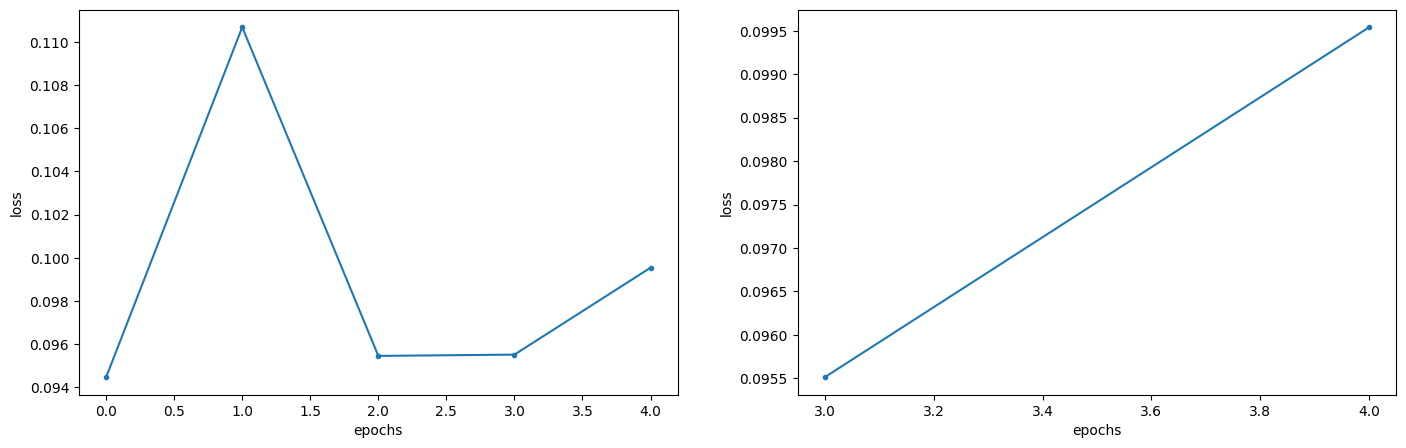

In [16]:
plot_hist(hist)

Text(0.5, 1.0, 'atlas')

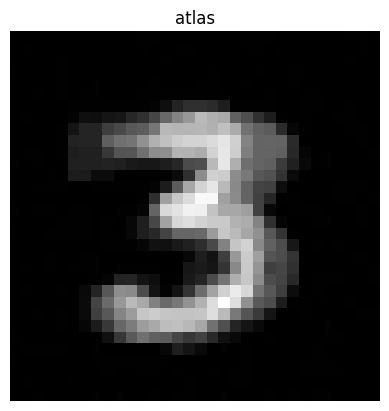

In [16]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(atlas, cmap='gray')
plt.axis('off');
plt.title('atlas')

In [ ]:
m = model.references.atlas_layer.get_weights()

In [11]:
import nibabel as nib

In [12]:
files = ['./data/mri-slice/' + f + '/slice_norm.nii.gz' for f in os.listdir('./data/mri-slice') if f.startswith('OASIS_OAS1_')]
vols = [nib.load(f).get_fdata() for f in files]
x_vols = np.stack(vols, 0)
vol_shape = x_vols.shape[1:-1]
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])
mean_atlas = np.mean(x_vols, 0,keepdims=True)
model.set_atlas(mean_atlas)
# prepare losses

image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

LocalParamWithInput: Consider using neuron.layers.LocalParam()
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow 

2023-08-14 21:00:50.053892: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-14 21:00:50.055280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-14 21:00:50.100538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:4f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-08-14 21:00:50.100952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:52:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-08-14 21:00:50.101326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:56:00.0 na

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2023-08-14 21:00:55.617358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 21:00:55.628266: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-14 21:00:55.628312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-08-14 21:00:55.628319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      
2023-08-14 21:00:55.775617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-08-14 21:00:56.377862: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000000000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
# train
gen = template_gen(x_vols, batch_size=2)
hist = model.fit(gen, epochs=100, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

2023-08-14 21:02:07.184948: W tensorflow/c/c_api.cc:326] Operation '{name:'vxm_dense_flow_resize/map/while' id:847 op device:{} def:{{{node vxm_dense_flow_resize/map/while}} = StatelessWhile[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_INT32, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=249, _read_only_resource_inputs=[], body=vxm_dense_flow_resize_map_while_body_335[], cond=vxm_dense_flow_resize_map_while_cond_334[], output_shapes=[[], [], [], [], [], ..., [], [], [], [], []], parallel_iterations=10](vxm_dense_flow_resize/map/while/loop_counter, vxm_dense_flow_resize/map/strided_slice, vxm_dense_flow_resize/map/Const, vxm_dense_flow_resize/map/TensorArrayV2_1, vxm_dense_flow_resize/map/strided_slice, vxm_dense_flow_resize/map/TensorArrayUnstack/TensorListFromTensor, vxm_dense_flow_resize/map/while/EmptyTensorList, vxm_dense_flow_resize/map/while/EmptyTensorList_1, vxm_dense_flow_resize/map/while/EmptyTensorL

In [36]:
K.eval(model.weights[-1])

array([0.], dtype=float32)

TypeError: Invalid shape () for image data

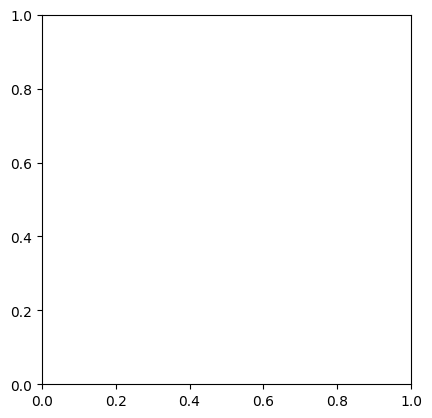

In [35]:
plt.imshow(K.eval(model.weights[-1])[...,0])

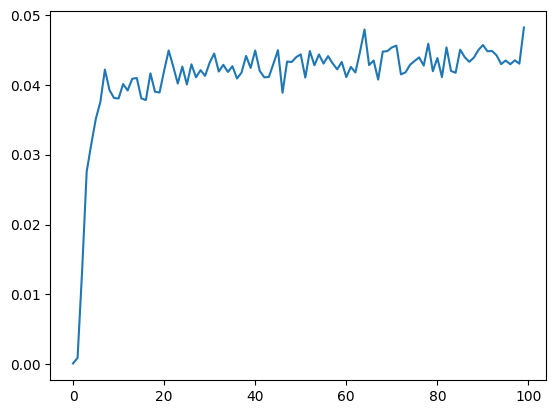

In [37]:
plt.plot(hist.history['vxm_dense_diffflow_loss'])

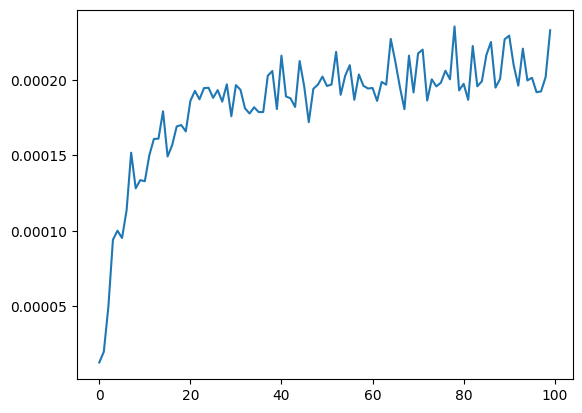

In [26]:
plt.plot(hist.history['mean_stream_loss'])

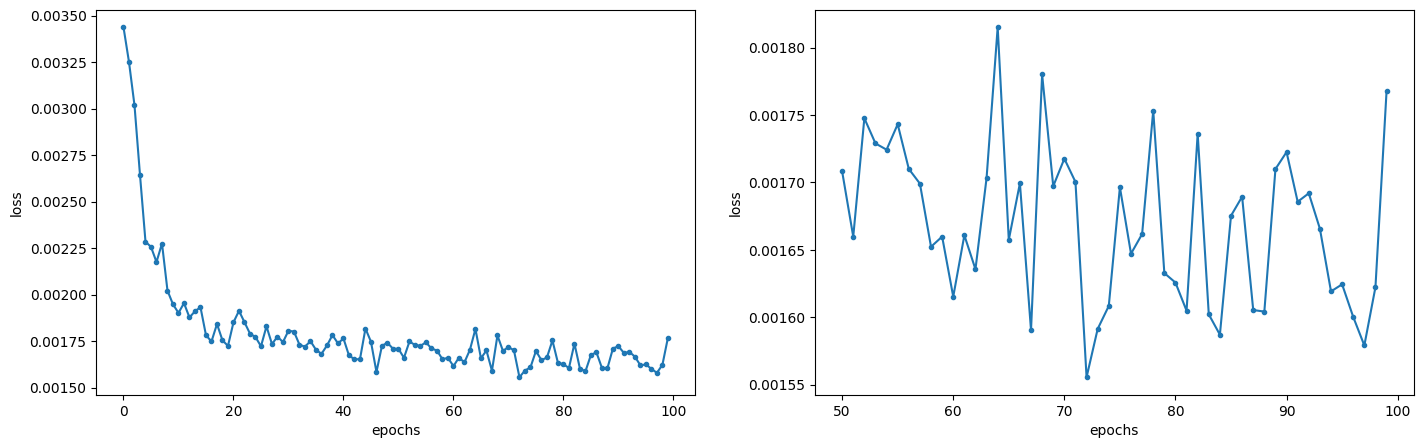

In [15]:
plot_hist(hist)

Text(0.5, 1.0, 'atlas')

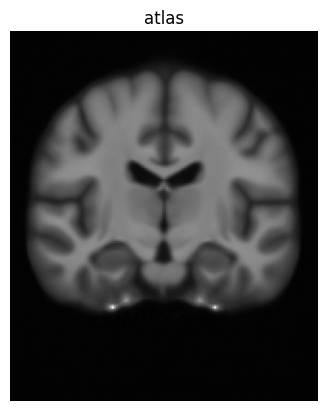

In [16]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(atlas.T, cmap='gray')
plt.axis('off');
plt.title('atlas')